# Testing Python interface to GASP

In [1]:
%matplotlib inline

In [2]:
import numpy as np  # Grids are stored as NumPy Arrays
import gasp         # GASP is what we're testing
import sys          # Needed to query size in bytes of data returned
import matplotlib.pyplot as plt

Found 1 CUDA devices in this system
Device 0 : Quadro P2000
Number of SMs       : 8
Max SHMEM per block : 48 KB
Max Opt in shared   : 48 KB
Recommended ngrids  : 1024

Estimated largest L for shared memory code path : 109
(Assumes threadsPerBlock = 32)

Using CUDA device : 0


### Run a nucleation swarm with suitable no. grids for GPU of L = 64 for upto 10000 MC sweeps

 Sweep :       9900, Reached cv =   0.90 :  761 , Unresolved :  263
CPU times: user 4.88 s, sys: 1.05 s, total: 5.93 s
Wall time: 18.1 s


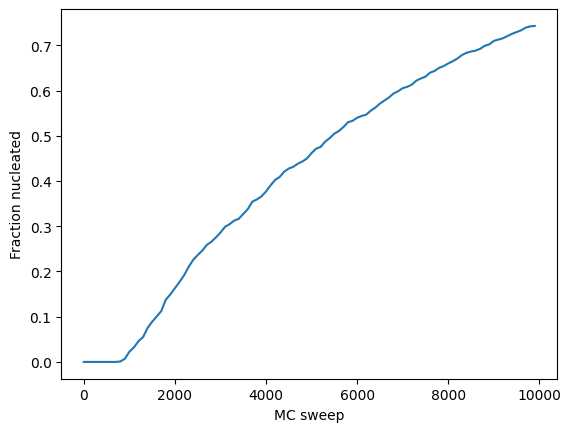

In [3]:
%%time

L = 64
ngrids = 4*gasp.gpu_nsms*32
nsweeps = 10000
beta = 0.54
h = 0.07

grid_output_int = 100 # Should be a multiple of mag_output_int (not enforced?)
mag_output_int  = 100 # Note that the collective variable (be it magnetisation or cluster size) is computed only at this interval

frac = gasp.run_nucleation_swarm(L, ngrids, nsweeps, beta, h, grid_output_int = grid_output_int, mag_output_int=mag_output_int);

sweeps = range(0, nsweeps, grid_output_int)
plt.xlabel("MC sweep")
plt.ylabel("Fraction nucleated")
plt.plot(sweeps, frac)

This will have populated `gasp.grids`, a list of snapshots, each of which is a list (one entry per grid replica) of objects with member properties inluding a 2D NumPy array representing the 2D Ising model. These arrays have type `np.int8` to save a bit of space. Note that only grids with collective variable (magnetisation by default) between `dn_threshold` and `up_threshold` are stored. These thresholds are $\pm 0.95$ by default. There may be sweeps at which no grids meet this criterion.

**WARNING**
The contents of `gasp.grids` gets overwritten every time we run a nucleation swarm or calculate a committor. If you want to keep the contents (e.g. select a grid and pass back into GASP to compute its committor) make a deep copy.

In [4]:
# Report on grids generated
nsnaps = len(gasp.grids)
print("Number of sweeps at which snapshots are stored     :",nsnaps)

bsize = sys.getsizeof(gasp.grids)
print("RAM allocated to hold grids (MB) :", (L*L*ngrids*len(gasp.grids) + 
                                           ngrids*len(gasp.grids)*sys.getsizeof(gasp.grids[0][0]))/(1024**2))

tot_grids = 0
for snaps in gasp.grids:
    tot_grids += len(snaps)
print("Total number of grids stored :", tot_grids, "out of ", nsweeps*ngrids//grid_output_int, "sampled")

#grid_nos = [ len(gasp.grids[i]) for i in range(nsnaps) ]
#print("ngrids at each snapshot        :",grid_nos)

print("Shape of each output grid : ", gasp.grids[4][0].grid.shape)

Number of sweeps at which snapshots are stored     : 99
RAM allocated to hold grids (MB) : 400.640625
Total number of grids stored : 55817 out of  102400 sampled
Shape of each output grid :  (64, 64)


## Examine the output
Plot a random replica at a random snapshot. Find all snapshots for that replica which have "interesting" magnetisation and store them.

isnap =  85 igrid =  273
magnetisaion :  -0.9306640625


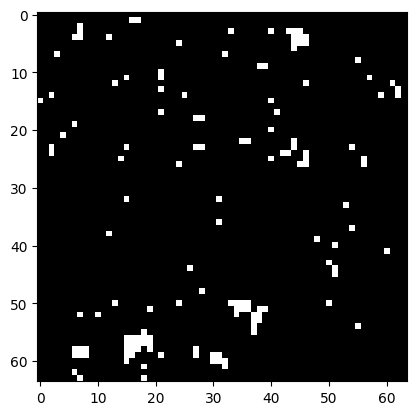

In [5]:
import matplotlib.pyplot as plt

# Visualise a random grid at a random sweep
isnap = np.random.randint(0, len(gasp.grids))
igrid = np.random.randint(0, len(gasp.grids[isnap]))
grid_data = np.array(gasp.grids[isnap][igrid].grid)

plt.imshow(grid_data, cmap='grey')
print("isnap = ", isnap, "igrid = ",igrid)
print("magnetisaion : ", gasp.grids[isnap][igrid].magnetisation)

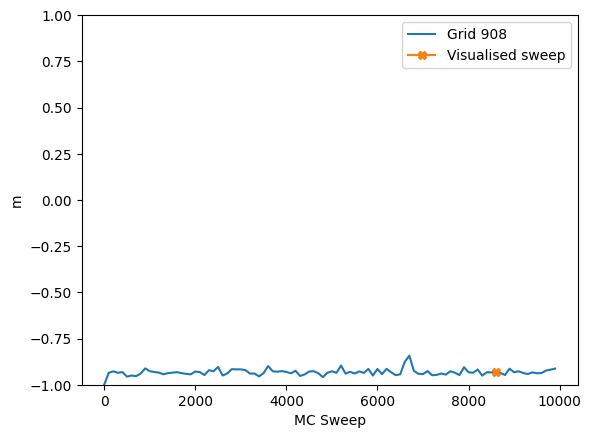

In [6]:
# Plot magnetisation vs time for grid igrid

jgrid = gasp.grids[isnap][igrid].igrid # Global index of this grid 

xdata = []
ydata = []
for imag, gridlist in enumerate(gasp.magnetisation):
    xdata.append(imag*mag_output_int)   
    ydata.append(gridlist[jgrid])

# Mark where the snapshot we picked above appears
x2data = gasp.grids[isnap][igrid].isweep
y2data = gasp.grids[isnap][igrid].magnetisation

lstring = "Grid "+str(jgrid)
plt.plot(xdata, ydata, label=lstring)
plt.plot(x2data, y2data, marker='X', label="Visualised sweep")
plt.xlabel("MC Sweep")
plt.ylim(-1,1)
plt.ylabel("m")
plt.legend()

Most probable magnetisation in metastable state :  -0.9400000000000001


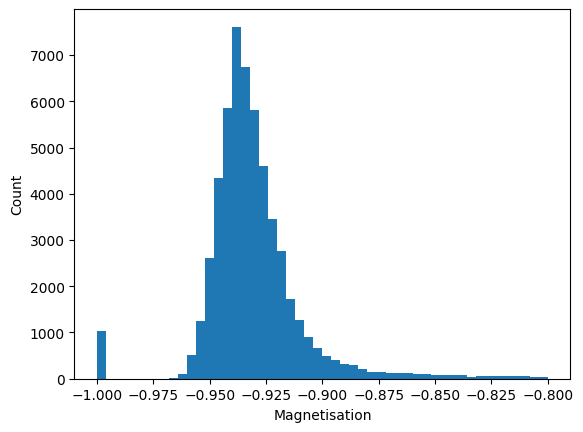

In [7]:
# What is the distribution of magnetisation in the initial (metastable) state?
all_mag = [m for ml in gasp.magnetisation for m in ml]

plt.xlabel("Magnetisation")
plt.ylabel("Count")
n, bins, _ = plt.hist(all_mag, range=(-1,-0.8), bins=50)
print("Most probable magnetisation in metastable state : ", bins[np.argmax(n)])

# Set this as the dn_threshold for committor calcs
dn_thr = bins[np.argmax(n)]

In [8]:
# Find the grids where the magnetisation is between -0.85 +/- 0.2
flat_grids_list = [ grid for grids in gasp.grids for grid in grids ]
sample_snaps = [ snap for snap in flat_grids_list if ( abs(snap.magnetisation + 0.85) < 0.2 ) ]
print("Selected ", len(sample_snaps), "snapshots")

# Make sure we work off a copy of this as the data behind gasp.grids will be destroyed when we do a pB calc
import copy
loc_sample_snaps = copy.deepcopy(sample_snaps)

Selected  51762 snapshots


isnap =  85 igrid =  273
magnetisation :  -0.9326171875


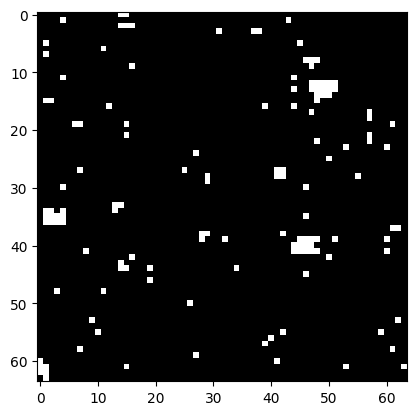

In [9]:
# Plot the first one and save it to file so we can use it again if we want
if (len(loc_sample_snaps)) > 0:
    plt.imshow(loc_sample_snaps[0].grid, cmap='grey')
    print("isnap = ", isnap, "igrid = ",igrid)
    print("magnetisation : ", loc_sample_snaps[0].magnetisation)
    np.save('sample.npy', loc_sample_snaps[0].grid)

In [10]:
# Calculate committor of all these snapshots
nsweeps = 50000
pB = []

if (len(loc_sample_snaps)) > 0:
    for isnap, snap in enumerate(loc_sample_snaps):

        if (isnap == gasp.gpu_nsms): break  # While debugging, only care about enough grids to populate GPU below
        
        frac = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=10000, grid_input="NumPy", dn_threshold=dn_thr, grid_array=[snap.grid])
        pB.append(frac)

 Sweep :       2300, Reached cv =  -0.94 :  968 , Reached cv =   0.90 :   56 , Unresolved :    0
 Sweep :       2100, Reached cv =  -0.94 :  784 , Reached cv =   0.90 :  240 , Unresolved :    0
 Sweep :       2200, Reached cv =  -0.94 :  967 , Reached cv =   0.90 :   57 , Unresolved :    0
 Sweep :       1800, Reached cv =  -0.94 :  966 , Reached cv =   0.90 :   58 , Unresolved :    0
 Sweep :       2600, Reached cv =  -0.94 :  945 , Reached cv =   0.90 :   79 , Unresolved :    0
 Sweep :       2800, Reached cv =  -0.94 :  976 , Reached cv =   0.90 :   48 , Unresolved :    0
 Sweep :       2200, Reached cv =  -0.94 :  961 , Reached cv =   0.90 :   63 , Unresolved :    0
 Sweep :          0, Reached cv =  -0.94 : 1024 , Reached cv =   0.90 :    0 , Unresolved :    0


In [11]:
# Find the ones which are interesting (if any)
iint = [ i for i in range(len(pB)) if pB[i][0][0] > 0.0 and pB[i][0][0] < 1.0 ]
print("Found ", len(iint), "interesting grids")
pB

Found  7 interesting grids


[[(0.0546875, 0.006845876732911617)],
 [(0.234375, 0.013130272217236014)],
 [(0.0556640625, 0.007258188108550629)],
 [(0.056640625, 0.00732728948396055)],
 [(0.0771484375, 0.008632950476570292)],
 [(0.046875, 0.006591051705834655)],
 [(0.0615234375, 0.0075698190072768555)],
 [(0.0, 0.0)]]

pB =  [(0.0546875, 0.006845876732911617)]


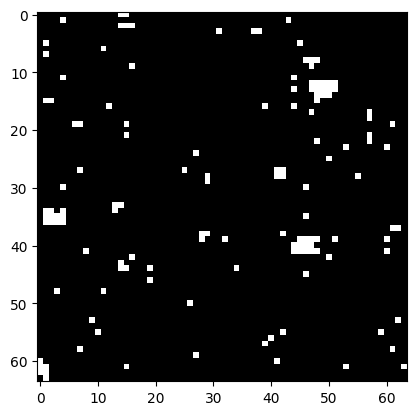

pB =  [(0.234375, 0.013130272217236014)]


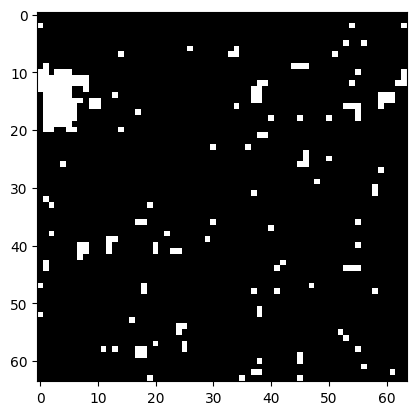

pB =  [(0.0556640625, 0.007258188108550629)]


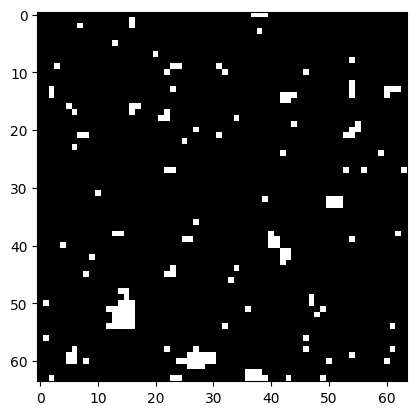

pB =  [(0.056640625, 0.00732728948396055)]


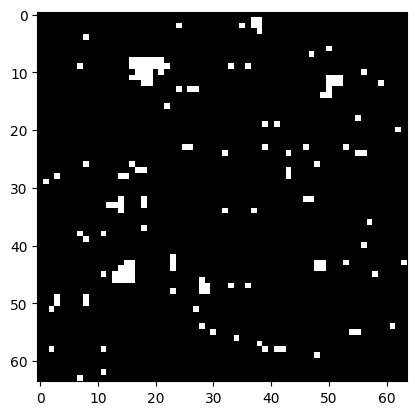

pB =  [(0.0771484375, 0.008632950476570292)]


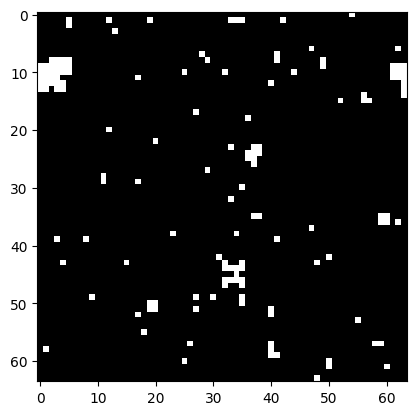

pB =  [(0.046875, 0.006591051705834655)]


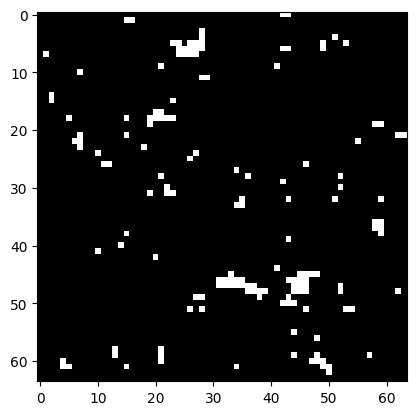

pB =  [(0.0615234375, 0.0075698190072768555)]


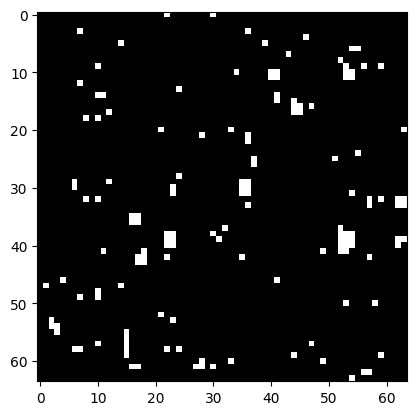

In [12]:
for i in iint:
    print("pB = ", pB[i])
    plt.imshow(loc_sample_snaps[i].grid, cmap='grey')
    plt.show()

## Compute pB for multiple snapshots at once using a fraction of the GPU for each
i.e. pass a list of NumPy arrays to `gasp.run_committor_calc`. Be careful to ensure the length of the list is such that a whole number of SMs on the GPU will be allocated to each snapshot in the list.

WARNING - this section won't do much if there aren't at least `gasp.gpu_nsms` interesting generated at based on the criteria above.

In [13]:
# For purposes of dividing up multiple committor calcs onto a single GPU, it is useful to reference the number of streaming multiprocessors
# (SMs) on the GPU we're working with. We should run a maximum of gpu_nsms x 4 grids at once on each GPU
gpu_nsms = gasp.gpu_nsms

# Calculate committor of all these snapshots using 1/gpu_nsms of a GPU for each
snapslist = [grid.grid for grid in loc_sample_snaps[0:gpu_nsms]] 
if len(snapslist)==gasp.gpu_nsms:
    print("Number of grids passed in : ",len(snapslist))
    pBfast = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=10000, grid_input="NumPy", grid_array=snapslist)

for pB in pBfast:
    print("pB = ",pB[0], "+/- ", pB[1])

Number of grids passed in :  8
 Sweep :       1400, Reached cv =  -0.93 :  978 , Reached cv =   0.90 :   46 , Unresolved :    0
pB =  0.0 +/-  0.0
pB =  0.21875 +/-  0.03488051044860544
pB =  0.03125 +/-  0.013019816040989632
pB =  0.015625 +/-  0.010577059749907332
pB =  0.046875 +/-  0.019067113193066136
pB =  0.0390625 +/-  0.018301999958378907
pB =  0.0078125 +/-  0.0079402023281003
pB =  0.0 +/-  0.0


In [14]:
# Calculate using twice the SMs per snapshot
if len(snapslist)==gpu_nsms:
    pBfast1 = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=10000, grid_input="NumPy", grid_array=snapslist[0:gpu_nsms//2])
    pBfast2 = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=10000, grid_input="NumPy", grid_array=snapslist[gpu_nsms//2:gpu_nsms])
    pBfast = pBfast1 + pBfast2

for pB in pBfast:
    print("pB = ",pB[0], "+/- ", pB[1])

 Sweep :       1300, Reached cv =  -0.93 :  944 , Reached cv =   0.90 :   80 , Unresolved :    0
 Sweep :       1400, Reached cv =  -0.93 :  999 , Reached cv =   0.90 :   25 , Unresolved :    0
pB =  0.0 +/-  0.0
pB =  0.24609375 +/-  0.02687706079316624
pB =  0.03515625 +/-  0.011915736784311862
pB =  0.03125 +/-  0.010714832067396336
pB =  0.05859375 +/-  0.014281150581714985
pB =  0.0234375 +/-  0.00940177937261137
pB =  0.015625 +/-  0.007857194844606492
pB =  0.0 +/-  0.0


In [15]:
# Calculate using 4x the SMs per snapshot
if len(snapslist)==gpu_nsms:
    pBfast1 = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=10000, grid_input="NumPy", grid_array=snapslist[0:gpu_nsms//4])
    pBfast2 = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=10000, grid_input="NumPy", grid_array=snapslist[gpu_nsms//4:gpu_nsms//2])
    pBfast3 = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=10000, grid_input="NumPy", grid_array=snapslist[gpu_nsms//2:3*gpu_nsms//4])
    pBfast4 = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=10000, grid_input="NumPy", grid_array=snapslist[3*gpu_nsms//4:gpu_nsms])
    pBfast = pBfast1 + pBfast2 + pBfast3 + pBfast4

for pB in pBfast:
    print("pB = ",pB[0], "+/- ", pB[1])

 Sweep :       1500, Reached cv =  -0.93 :  915 , Reached cv =   0.90 :  109 , Unresolved :    0
 Sweep :       1400, Reached cv =  -0.93 :  993 , Reached cv =   0.90 :   31 , Unresolved :    0
 Sweep :       1600, Reached cv =  -0.93 :  980 , Reached cv =   0.90 :   44 , Unresolved :    0
 Sweep :       1300, Reached cv =  -0.93 : 1006 , Reached cv =   0.90 :   18 , Unresolved :    0
pB =  0.0 +/-  0.0
pB =  0.212890625 +/-  0.01765185199826258
pB =  0.033203125 +/-  0.007930916164841015
pB =  0.02734375 +/-  0.006980253930087148
pB =  0.044921875 +/-  0.008990832786028503
pB =  0.041015625 +/-  0.008754608884814077
pB =  0.03515625 +/-  0.00790284121739393
pB =  0.0 +/-  0.0


## Experiment with synthetic configurations
Create a square or a circle region of spin up and compute the committor of that configuration

 Sweep :       1500, Reached cv =  -0.93 :  205 , Reached cv =   0.90 :  819 , Unresolved :    0
pB =  [(0.7998046875, 0.011668670046411448)]


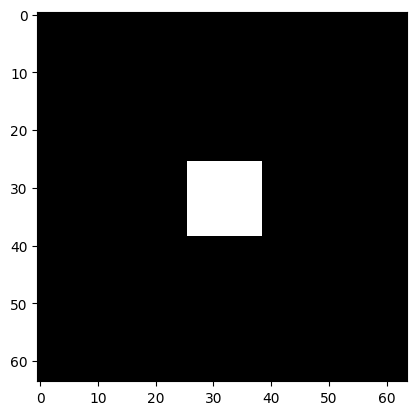

In [16]:
import math as m

# Create a synthetic grid
new_grid = np.ones((L,L),dtype=np.int8)
centre = (L/2, L/2)
size = 6

for irow in range(L):
    for icol in range(L):

        # Square
        if ( abs(irow - centre[1]) > size) or abs(icol - centre[0]) > size:
            new_grid[irow][icol] = -1
        
        # Circle
        #dist = m.sqrt( (irow - centre[1])**2 + (icol - centre[0])**2 )
        #if dist > size:
        #    new_grid[irow][icol] = -1

plt.imshow(new_grid, cmap='grey')
frac = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=100, grid_input="NumPy", grid_array=[new_grid])
print("pB = ", frac)

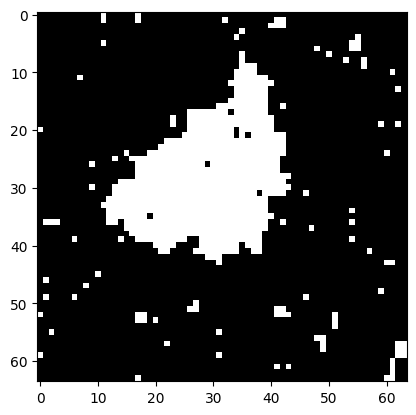

In [17]:
# Have a look at what the initial configuration evolved to after a few snapshots on a random grid
igrid = np.random.randint(0, ngrids)
plt.imshow(gasp.grids[3][242].grid,cmap='grey')

In [18]:
# Use the synthetic config to sanity check the error bar calculation. Run 10 repeats of the pB calculation
pB_repeats = []
for i in range(10):
    frac = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=100, grid_input="NumPy", grid_array=[new_grid])
    pB_repeats.append(frac)
pB_repeats

 Sweep :       2000, Reached cv =  -0.93 :  211 , Reached cv =   0.90 :  813 , Unresolved :    0
 Sweep :       1500, Reached cv =  -0.93 :  227 , Reached cv =   0.90 :  797 , Unresolved :    0
 Sweep :       1500, Reached cv =  -0.93 :  208 , Reached cv =   0.90 :  816 , Unresolved :    0
 Sweep :       1500, Reached cv =  -0.93 :  196 , Reached cv =   0.90 :  828 , Unresolved :    0
 Sweep :       1600, Reached cv =  -0.93 :  251 , Reached cv =   0.90 :  773 , Unresolved :    0
 Sweep :       1500, Reached cv =  -0.93 :  211 , Reached cv =   0.90 :  813 , Unresolved :    0
 Sweep :       1700, Reached cv =  -0.93 :  240 , Reached cv =   0.90 :  784 , Unresolved :    0
 Sweep :       1800, Reached cv =  -0.93 :  204 , Reached cv =   0.90 :  820 , Unresolved :    0
 Sweep :       1500, Reached cv =  -0.93 :  254 , Reached cv =   0.90 :  770 , Unresolved :    0
 Sweep :       1600, Reached cv =  -0.93 :  232 , Reached cv =   0.90 :  792 , Unresolved :    0


[[(0.7939453125, 0.012838610848061802)],
 [(0.7783203125, 0.013515529880083883)],
 [(0.796875, 0.012652698414635413)],
 [(0.80859375, 0.012433872172443908)],
 [(0.7548828125, 0.014131493245882379)],
 [(0.7939453125, 0.012686713587947387)],
 [(0.765625, 0.013059741547902438)],
 [(0.80078125, 0.012697063838761864)],
 [(0.751953125, 0.013472514774539385)],
 [(0.7734375, 0.013418334649802367)]]

In [19]:
# What is the standard error estimate on the average of pB over those repeats
pB_vals = np.array([ val[0][0] for val in pB_repeats ])
bf_err = np.std(pB_vals)/m.sqrt(len(pB_vals))
print("Estimate from 10 repeats : ", np.mean(pB_vals), " +/- ", bf_err) 

Estimate from 10 repeats :  0.7818359375  +/-  0.0059661495275887


In [20]:
# A single repeat has a sample size 10 times smaller, and so from a single calculation we'd expect the error to be sqrt(10) times larger
print("Expected error from single repeat : ", bf_err*m.sqrt(len(pB_vals)))

Expected error from single repeat :  0.018866621368317876


In [21]:
# This is about what we're estimating via bootstrapping from a single calc, so all good.

## Experiment with using largest cluster size rather than magnetisation to set thresholds
We'll now need to specify the arguments `up_threshold` and `dn_threshold` since the defaults are for magnetisation.

In [22]:
%%time

L = 64
ngrids = 4*gasp.gpu_nsms*32
nsweeps = 10000
beta = 0.54
h = 0.07

grid_output_int = 100 # Should be a multiple of mag_output_int (not enforced?)
mag_output_int  = 100 # Note that the collective variable (be it magnetisation or cluster size) is computed only at this interval

frac = gasp.run_nucleation_swarm(L, ngrids, nsweeps, beta, h, 
                                 cv='largest_cluster', up_threshold=1000, dn_threshold=15, 
                                 grid_output_int = grid_output_int,
                                 mag_output_int = mag_output_int);

 Sweep :       9900, Reached cv = 1000.00 :  800 , Unresolved :  224
CPU times: user 8.36 s, sys: 1.01 s, total: 9.37 s
Wall time: 20.9 s


Text(0, 0.5, 'N')

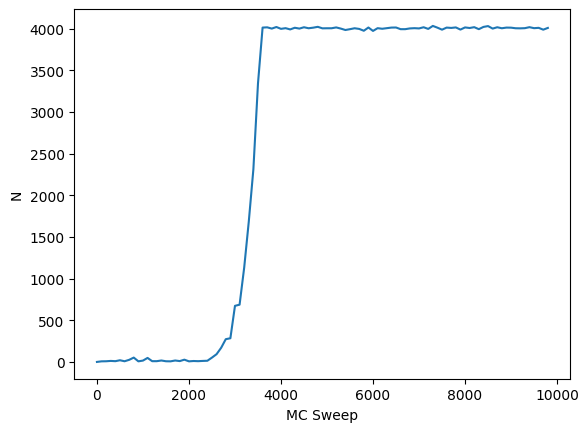

In [23]:
# Plot largest cluster size against time for some random igrid. Repeat this a few times to see how high
# an N do the non-nucleated trajectories reach before returning to low N. That helps decide where to set
# the lowest threshold for pB calcs.
igrid = np.random.randint(0, ngrids)

xdata = []
ydata = []
for isnap, gridlist in enumerate(gasp.grids):
    xdata.append(isnap*grid_output_int)
    ydata.append(gasp.largest_cluster[isnap][igrid])

plt.plot(xdata,ydata)

plt.xlabel("MC Sweep")
plt.ylabel("N")

In [28]:
# Find the grids where the largest cluster size is between 50 and 150
flat_grids_list = [ grid for grids in gasp.grids for grid in grids ]
sample_snaps = [ snap for snap in flat_grids_list if ( snap.lclus_size > 50 and snap.lclus_size < 150 ) ]
print("Selected ", len(sample_snaps), "snapshots")

# Make sure we work off a copy of this as the data behind gasp.grids will be destroyed when we do a pB calc
import copy
loc_sample_snaps = copy.deepcopy(sample_snaps)

Selected  3359 snapshots


In [29]:
# Calculate committor of all these snapshots
nsweeps = 50000
pB_clus = []

if (len(loc_sample_snaps)) > 0:
    for isnap, snap in enumerate(loc_sample_snaps):

        if (isnap == gasp.gpu_nsms): break  # While debugging, only care about enough grids to populate GPU below
        
        frac = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h,
                                       cv='largest_cluster', up_threshold=3000, dn_threshold=10, 
                                       grid_output_int=10000, grid_input="NumPy", grid_array=[snap.grid])
        pB_clus.append(frac)

 Sweep :       2500, Reached cv =  10.00 :  856 , Reached cv = 3000.00 :  168 , Unresolved :    0
 Sweep :       2200, Reached cv =  10.00 :  827 , Reached cv = 3000.00 :  197 , Unresolved :    0
 Sweep :       2400, Reached cv =  10.00 :  791 , Reached cv = 3000.00 :  233 , Unresolved :    0
 Sweep :       1800, Reached cv =  10.00 :  366 , Reached cv = 3000.00 :  658 , Unresolved :    0
 Sweep :       2200, Reached cv =  10.00 :  402 , Reached cv = 3000.00 :  622 , Unresolved :    0
 Sweep :       2400, Reached cv =  10.00 :  746 , Reached cv = 3000.00 :  278 , Unresolved :    0
 Sweep :       2100, Reached cv =  10.00 :  869 , Reached cv = 3000.00 :  155 , Unresolved :    0
 Sweep :       2100, Reached cv =  10.00 :  465 , Reached cv = 3000.00 :  559 , Unresolved :    0


In [35]:
# Calculate committor of all these snapshots using magnetisation and compare
nsweeps = 50000
pB_mag = []

if (len(loc_sample_snaps)) > 0:
    for isnap, snap in enumerate(loc_sample_snaps):

        if (isnap == gasp.gpu_nsms): break  # While debugging, only care about enough grids to populate GPU below
        
        frac = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h,
                                       cv='magnetisation', up_threshold=0.9, dn_threshold=-0.93, 
                                       grid_output_int=10000, grid_input="NumPy", grid_array=[snap.grid])
        pB_mag.append(frac)

for i in range(len(pB_clus)):
    print("pB_clus = ", pB_clus[i], "pB_mag = ", pB_mag[i])

 Sweep :       1600, Reached cv =  -0.93 :  891 , Reached cv =   0.90 :  133 , Unresolved :    0
 Sweep :       2000, Reached cv =  -0.93 :  854 , Reached cv =   0.90 :  170 , Unresolved :    0
 Sweep :       1400, Reached cv =  -0.93 :  813 , Reached cv =   0.90 :  211 , Unresolved :    0
 Sweep :       1600, Reached cv =  -0.93 :  381 , Reached cv =   0.90 :  643 , Unresolved :    0
 Sweep :       1500, Reached cv =  -0.93 :  437 , Reached cv =   0.90 :  587 , Unresolved :    0
 Sweep :       1800, Reached cv =  -0.93 :  754 , Reached cv =   0.90 :  270 , Unresolved :    0
 Sweep :       1600, Reached cv =  -0.93 :  883 , Reached cv =   0.90 :  141 , Unresolved :    0
 Sweep :       1600, Reached cv =  -0.93 :  483 , Reached cv =   0.90 :  541 , Unresolved :    0
pB_clus =  [(0.1640625, 0.010902937168019053)] pB_mag =  [(0.1298828125, 0.010435425931730972)]
pB_clus =  [(0.1923828125, 0.012227216623899919)] pB_mag =  [(0.166015625, 0.011750553110317547)]
pB_clus =  [(0.2275390625, 0.0

In [31]:
# Find the ones which are interesting (if any) based on largest cluster pB
iint = [ i for i in range(len(pB_clus)) if pB_clus[i][0][0] > 0.0 and pB_clus[i][0][0] < 1.0 ]
print("Found ", len(iint), "interesting grids")
iint

Found  8 interesting grids


[0, 1, 2, 3, 4, 5, 6, 7]

pB =  [(0.1640625, 0.010902937168019053)] largest cluster size =  60.0


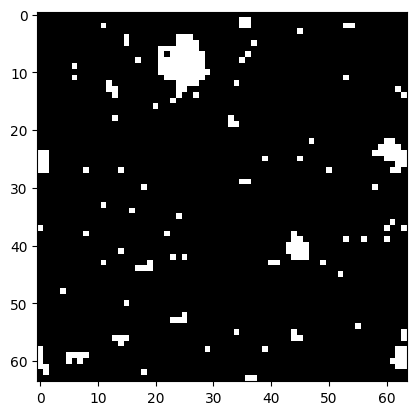

pB =  [(0.1923828125, 0.012227216623899919)] largest cluster size =  72.0


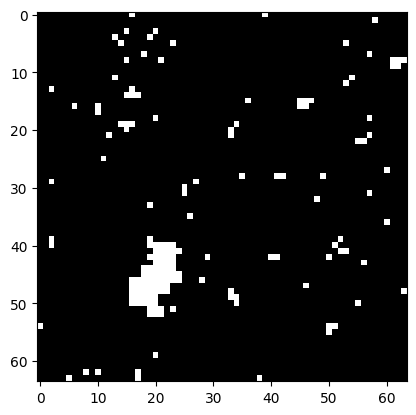

pB =  [(0.2275390625, 0.013167367126894869)] largest cluster size =  78.0


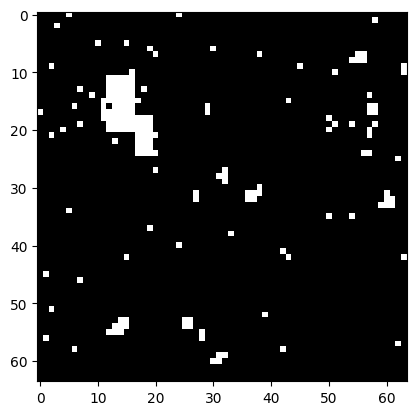

pB =  [(0.642578125, 0.015039197959653668)] largest cluster size =  129.0


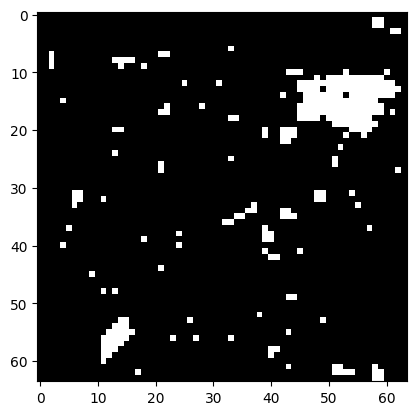

pB =  [(0.607421875, 0.014650980286636)] largest cluster size =  135.0


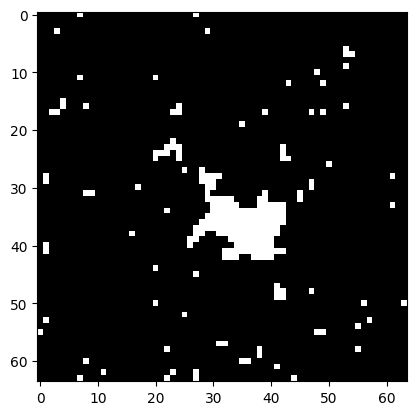

pB =  [(0.271484375, 0.013458445362725438)] largest cluster size =  83.0


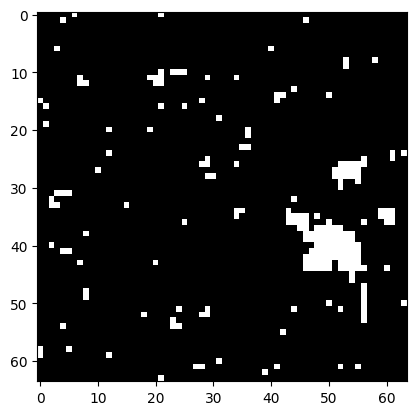

pB =  [(0.1513671875, 0.011098715339845548)] largest cluster size =  63.0


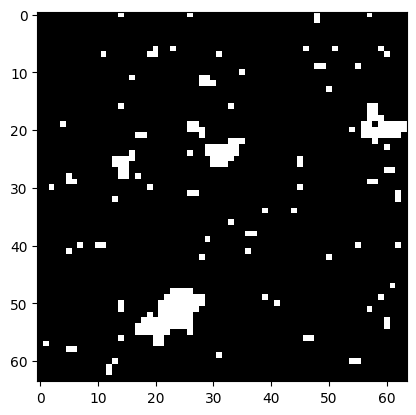

pB =  [(0.5458984375, 0.016057644930404114)] largest cluster size =  122.0


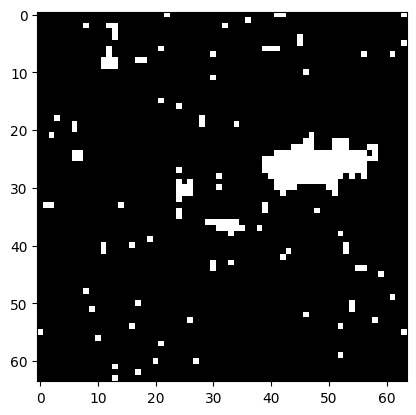

In [34]:
for i in iint:
    print("pB = ", pB_clus[i], "largest cluster size = ",  loc_sample_snaps[i].lclus_size, )
    plt.imshow(loc_sample_snaps[i].grid, cmap='grey')
    plt.show()